In [30]:
import numpy as np
import scipy.stats.mstats
import matplotlib.pyplot as plt
import sklearn.decomposition as decomp
import os
import sys
import pickle
from pyemd import emd
%matplotlib inline

# Copula Transform

**Main Idea:** If we know more information about the marginals/our joint distribution is very complicated, we can normalize the marginals and analyze the joint relationship more easily.

### Copula Transform

$$X = [X_1,\ \ldots\ , X_d], X \in \mathcal{R}^d$$
$$\text{CDFs of above: } P_i: [P_1,\ \ldots\ , P_d]$$
$$U = [U_1,\ \ldots\ , U_d] = [P_1(X_1),\ \ldots\ , P_d(X_d)]$$
By the **probability integral transform:** 
$$\forall\ i,\ U_i \sim \mathcal{U}[0, 1]$$

### Sklar's Theorem

Same setting as above. We add the definition of:
$$P = \text{ joint cumulative distribution}$$
$$C = \text{ copula, the distribution of uniform marginals}$$
$$P = C(P_1(X_1),\ \ldots\ , P_d(X_d))$$

### Empirical Copula

Same setting as above with the additional declaration of $X$ as a random vector with $X_i^t$ being sampled from it at each timestep:
$$X \in \mathcal{R}^d,\ t \in \{1,\ \ldots\ ,T \}\ \rightarrow \ (X_1^t,\ \ldots\ , X_d^t)$$

Additionally, we acknowledge probability depends on knowledge of prior. Rather than having a prior, calculate empirically:

$$P_i^T(x) = \frac{1}{T} \sum^T_{t=1} \mathbb{1}(X_i^t \leq x)$$

### Earth Mover's Distance

**Used to calculate intra-dependence with copula.** It practically uses the Hungarian Algorithm to solve an assignment problem.

$$\tilde{U}_1,\ \tilde{U}_2 \in [0, 1]^d$$
$$X_1, X_2 \in \mathcal{R}^{d \times T}$$

Using $X_1$ and $X_2$ and the empirical copula formula above, we construct histograms $h_1$ and $h_2$ to estimate $\tilde{U}_1$ and $\tilde{U}_2$. Histograms are converted into signatures:

$$s_1 = \{(p_i, w_{p_i})^n_{i=1}\},\ s_2 = \{(q_i, w_{q_i})^n_{i=1}\}$$
$$p_i, q_i \in [0, 1]^d$$

$$EMD(s_1, s_2) := min_f \sum_{1 \leq i,j \leq n} \Big\vert \Big\vert\ p_i − q_j\ \Big\vert \Big\vert\ f_{ij}$$
Subject to 
$$f_{ij} \geq 0, 1 \leq i, j \leq n$$
$$ \sum^n_{j=1}\ f_{ij} \leq w_{p_i},\ 1 \leq i \leq n$$
$$ \sum^n_{i=1}\ f_{ij} \leq w_{q_i},\ 1 \leq j \leq n$$
$$ \sum^n_{i=1} \sum^n_{j=1}\ f_{ij} = 1$$

***

In [8]:
def empirical_copula(X):
#     x_copula = 
#     y_copula = scipy.stats.mstats.rankdata(y) / len(y)
    return np.array([scipy.stats.mstats.rankdata(X[i, :]) / len(X[i, :]) for i in range(X.shape[0])])

In [9]:
##### FROM THEIR CODE
##### https://www.datagrapple.com/Tech/optimal-copula-transport.html
def eval_density(dcopula,u1,u2,bin_width):
    T = len(dcopula[0])
    proba = 0.0
    for t in range(0,T):
        if dcopula[0][t] > u1 and dcopula[0][t] <= u1+bin_width and \
           dcopula[1][t] > u2 and dcopula[1][t] <= u2+bin_width:
            proba += 1
            
    return proba / T
    
def build_density_copula(dcopula,nbBins=10):
    bin_width = 1.0 / nbBins
    m = bin_width / 2
    density_copula = np.zeros((nbBins,nbBins))
    bins_limit = np.linspace(0, 1, num=nbBins+1)[:nbBins]
    signatures = []
    
    for u1 in bins_limit:
        for u2 in bins_limit:
            ev_pr = eval_density(dcopula,u1,u2,bin_width)
            density_copula[round(u1/bin_width)][round(u2/bin_width)] = ev_pr
            signatures.append([np.array([u1+m,u2+m]),ev_pr])
                        
    return density_copula, signatures

def plot_copula_sample(X, ecopula, dcopula, title):
    fig = plt.figure(2,figsize=(20,5))
    fig.suptitle("Rotation of " + str(title) + " Radians \n (left) observations, \
                 (mid) pseudo-observations, (right) estimated density of the empirical copula", y=1.05, fontsize=20)
    fig.subplots_adjust(hspace=.5)
    ax = plt.subplot(1,3,1)
    ax.text(0.5, -0.1,'Bivariate Gaussian $\mathcal{N}(0,\Sigma)$', horizontalalignment='center',verticalalignment='center',transform=ax.transAxes,fontsize=16)
    ax.scatter(X[:,0],X[:,1])
    ax = plt.subplot(1,3,2)
    ax.text(0.5, -0.1,'Empirical copula transform', horizontalalignment='center',verticalalignment='center',transform=ax.transAxes,fontsize=16)
    ax.scatter(ecopula[0],ecopula[1])
    ax = plt.subplot(1,3,3)
    ax.text(0.5, -0.1,'Gaussian copula estimated density', horizontalalignment='center',verticalalignment='center',transform=ax.transAxes,fontsize=16)
    ax.pcolor(dcopula)
    plt.show()
    
def build_dist_mat(signatures):
    N = len(signatures)
    dist_mat = np.zeros((N,N))
    for i in range(0,len(signatures)):
        for j in range(i,len(signatures)):
            v1 = signatures[i][0]
            v2 = signatures[j][0]
            dist_mat[i,j] = np.linalg.norm(v1-v2)
            dist_mat[j,i] = dist_mat[i,j]
    
    return dist_mat

# Test Data

- Rotated 2D Gaussians
- High dimension Guassians, arbitrary locations

In [3]:
def gen_samples(params, dists):
    points = list()
    for dist in dists:
        points.append(_make_dist(params, dist))
    return points

def _rotate_points(X, theta):
    kernel = np.asarray([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    return np.dot(kernel, X)

def _make_dist(p_global, p_local):
    N = p_local.get('num_samples', p_global['num_samples'])
    if p_local['type'] == 'gaussian':
        X = np.random.multivariate_normal(p_local['mean'], p_local['cov'], N).T
    if 'transforms' in p_local.keys():
        if type(p_local['transforms']) != 'list':
            p_local['transforms'] = [p_local['transforms']]
        for transform in p_local['transforms']:
            if transform == 'rotate':
                X = _rotate_points(X, p_local['theta'])
    return X

In [4]:
def make_rotated_gaussians(n, n_rotations):
    core_params = {
        'num_samples': 5000
    }
    rotation_set = [
        {
            'type': 'gaussian',
            'mean': [0, 0],
            'transforms': 'rotate',
            'cov': [[.2, 0], [0, 1]],
            'theta': (i * np.pi / n_rotations)
        }
        for i in range(n_rotations)
    ]
    return gen_samples(core_params, rotation_set)

In [43]:
def _plot_copula(X, title):
    ecopula = empirical_copula(X)
    print ecopula
    dcopula, sig = build_density_copula(ecopula, 150)
    plot_copula_sample(X.T, ecopula, dcopula, title)

def _get_sig(X):
    ecopula = empirical_copula(X)
    dcopula, sig = build_density_copula(ecopula, 20)
    return sig

(2, 5000)
[[ 0.7826  0.23    0.5862 ...,  0.1038  0.5476  0.3538]
 [ 0.9482  0.0504  0.7716 ...,  0.3054  0.4386  0.7944]]


/home/nitin/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:22: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


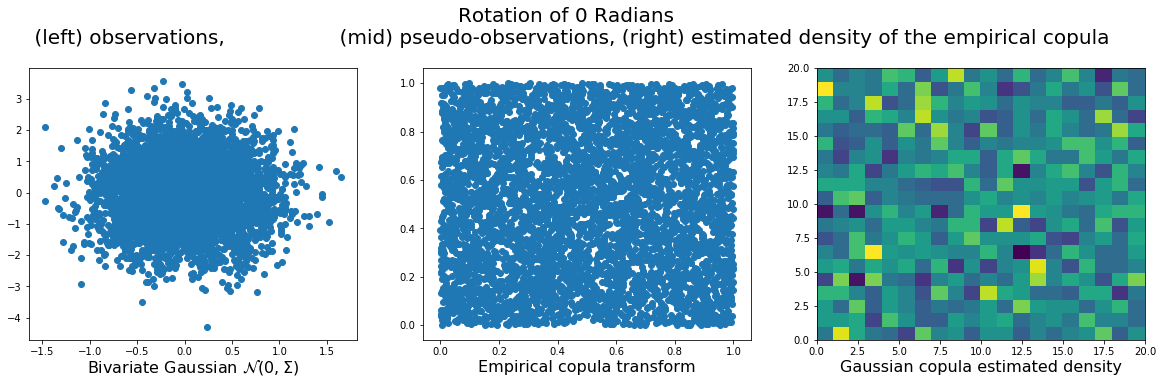

(2, 5000)
[[ 0.6174  0.5448  0.0244 ...,  0.4692  0.0638  0.172 ]
 [ 0.1054  0.455   0.876  ...,  0.3964  0.6134  0.4974]]


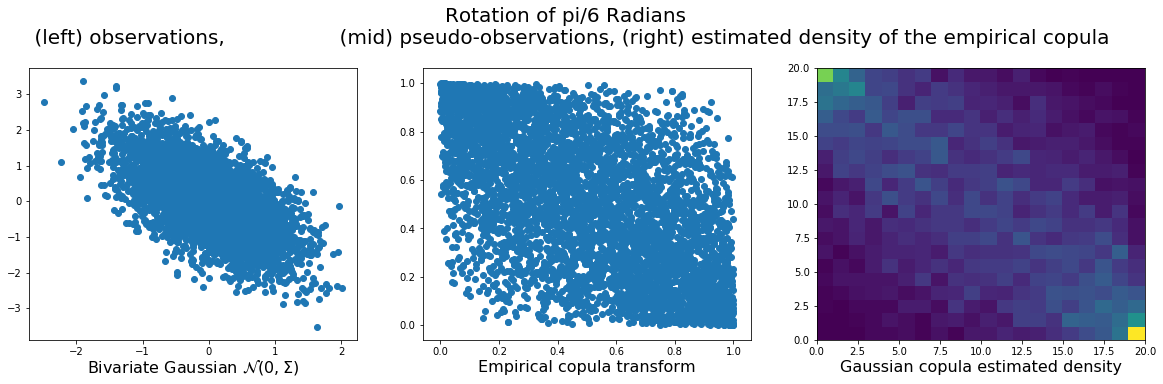

(2, 5000)
[[ 0.4738  0.7816  0.2164 ...,  0.7618  0.501   0.6072]
 [ 0.285   0.5388  0.8264 ...,  0.0532  0.3756  0.3746]]


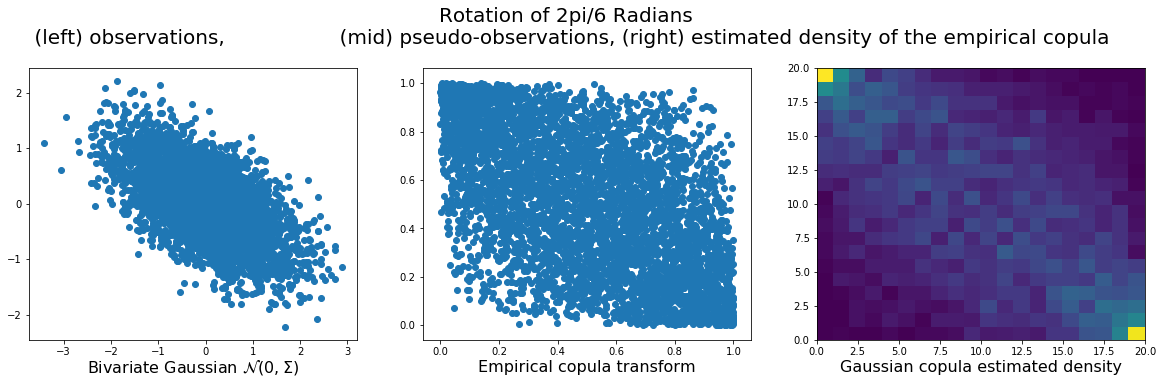

(2, 5000)
[[ 0.2048  0.566   0.6288 ...,  0.3826  0.0692  0.685 ]
 [ 0.4572  0.334   0.4146 ...,  0.5302  0.4612  0.3394]]


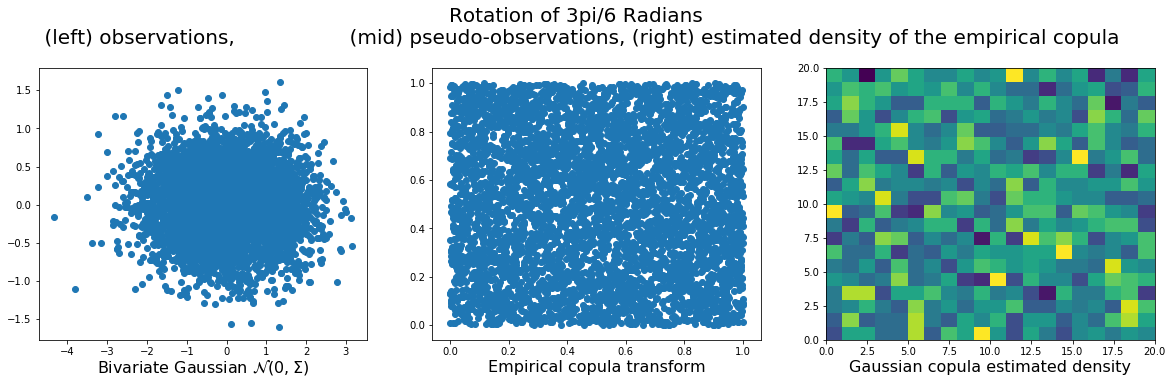

(2, 5000)
[[ 0.6258  0.3238  0.2054 ...,  0.688   0.4024  0.9032]
 [ 0.7946  0.591   0.0706 ...,  0.4904  0.2112  0.5136]]


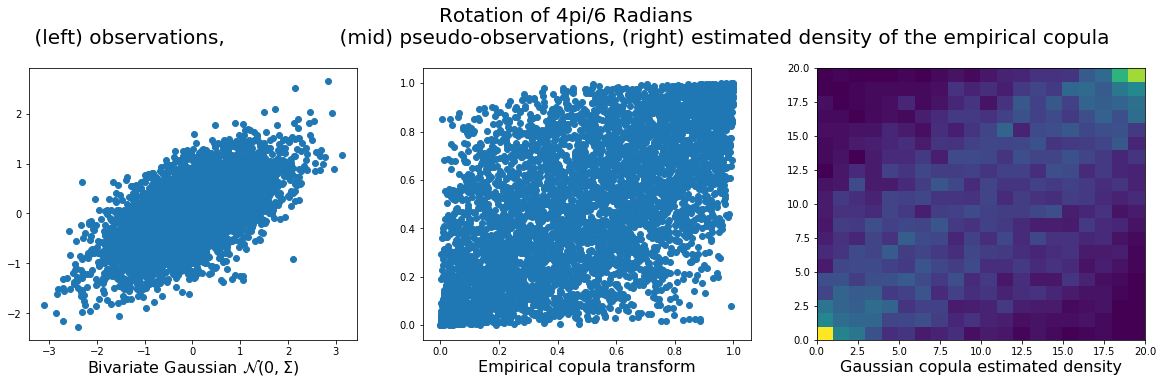

(2, 5000)
[[ 0.4538  0.4952  0.575  ...,  0.0908  0.6418  0.1392]
 [ 0.5504  0.8124  0.8136 ...,  0.132   0.791   0.2852]]


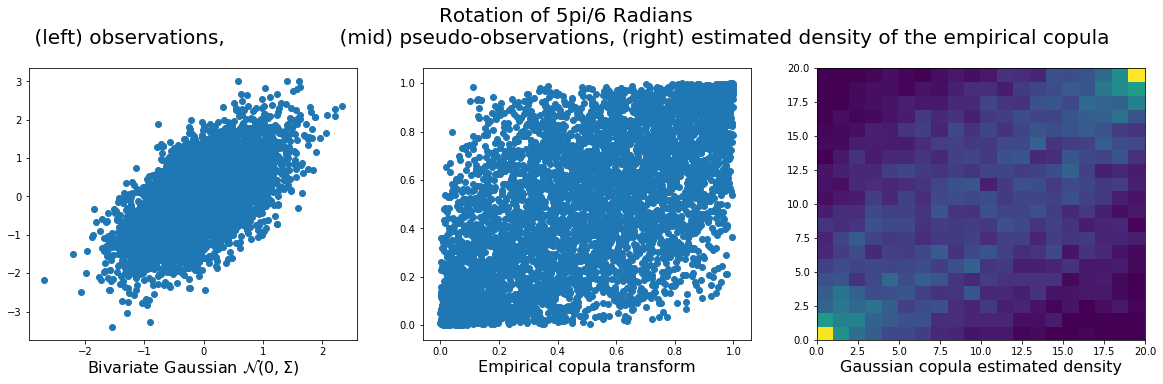

In [124]:
for i, pair in enumerate(make_rotated_gaussians(5000, 6)):
    title = str(i) + 'pi/' + str(6)
    if i == 0:
        title = str(i)
    if i == 1:
        title = 'pi/' + str(6)
        
    print pair.shape
    _plot_copula(pair, title)

In [33]:
# get sigs
sigs = []
for X in make_rotated_gaussians(5000, 6):
    sigs.append(_get_sig(X))

def _plot_distances(sigs):
    # get ground distance
    dist_mat = build_dist_mat(sigs[0])

    N = len(sigs)
    oct_dist = np.zeros((N,N))
    for i in range(N):
        sig_i = np.array([sigs[i][k][1] for k in range(len(sigs[i]))])
        for j in range(N):
            if j > i:
                sig_j = np.array([sigs[j][k][1] for k in range(len(sigs[j]))])
                oct_dist[i,j] = emd(sig_i,sig_j,dist_mat)
                oct_dist[j,i] = oct_dist[i,j]

    plt.pcolormesh(oct_dist)
    plt.colorbar()
    plt.title("Optimal Transport Distance Matrix")
    plt.show()

/home/nitin/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:22: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


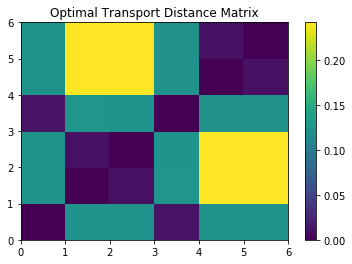

In [130]:
_plot_distances(sigs)

We see what we want! Rotations closer to each other are closer by this metric. **This is what we wanted!**

[[ 0.3488  0.2312  0.0794 ...,  0.5918  0.4678  0.0278]
 [ 0.7512  0.6332  0.1956 ...,  0.0842  0.3078  0.6492]]


/home/nitin/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:22: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


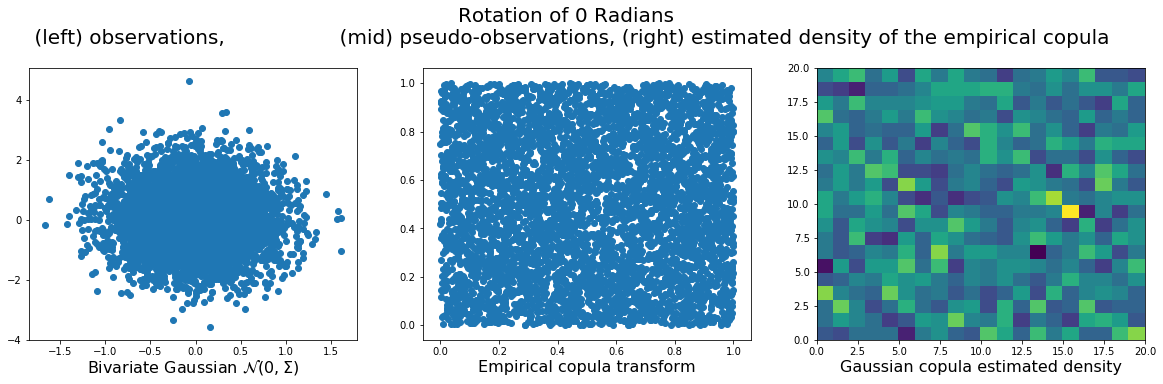

[[ 0.416   0.469   0.5486 ...,  0.1948  0.2122  0.9794]
 [ 0.966   0.9098  0.9504 ...,  0.0828  0.9324  0.0362]]


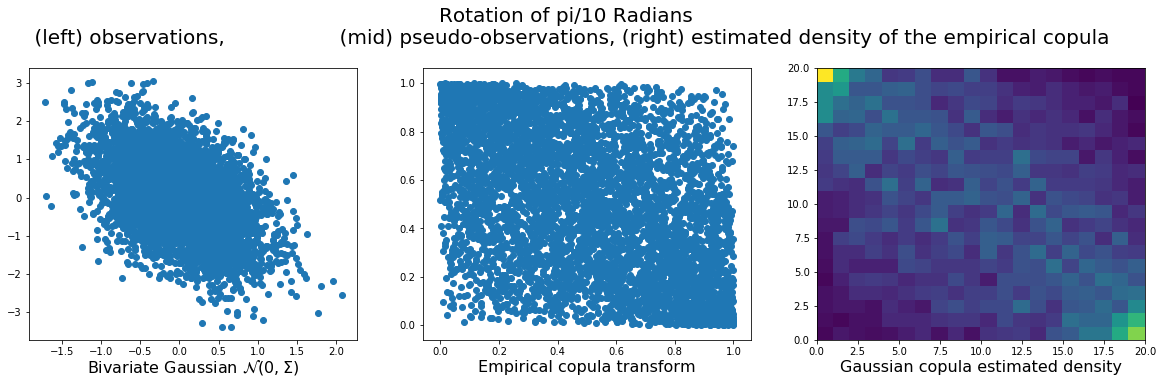

[[ 0.8448  0.5042  0.7006 ...,  0.1548  0.3676  0.0886]
 [ 0.0344  0.2138  0.3968 ...,  0.9846  0.8188  0.8338]]


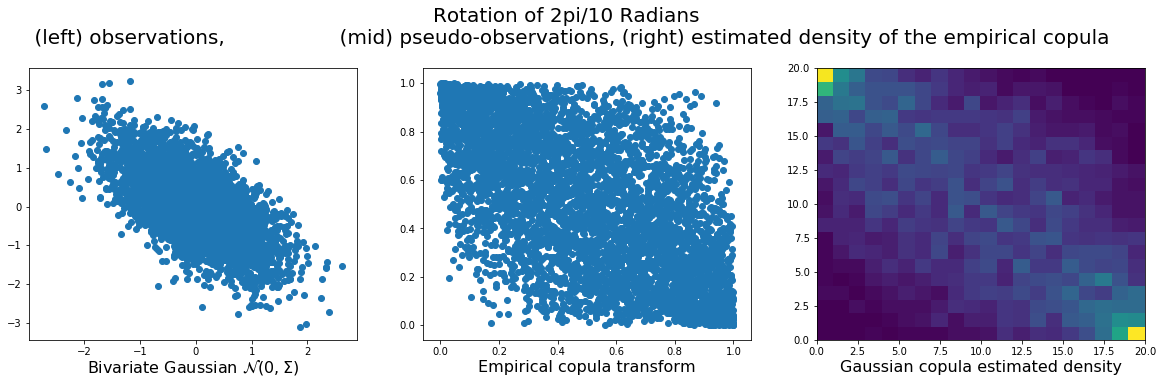

[[ 0.2874  0.5498  0.1196 ...,  0.782   0.5662  0.8054]
 [ 0.304   0.342   0.719  ...,  0.1456  0.4896  0.7644]]


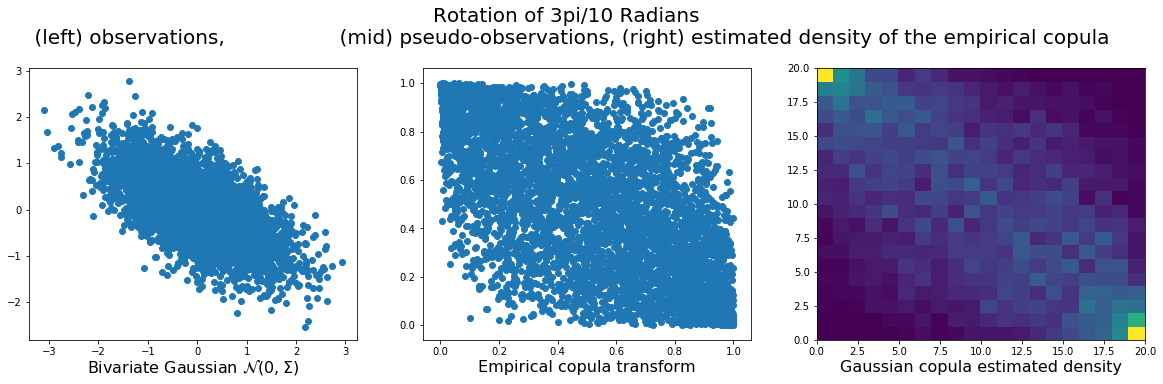

[[ 0.3382  0.1664  0.5526 ...,  0.4586  0.9584  0.4012]
 [ 0.5082  0.8552  0.8094 ...,  0.4558  0.3682  0.2142]]


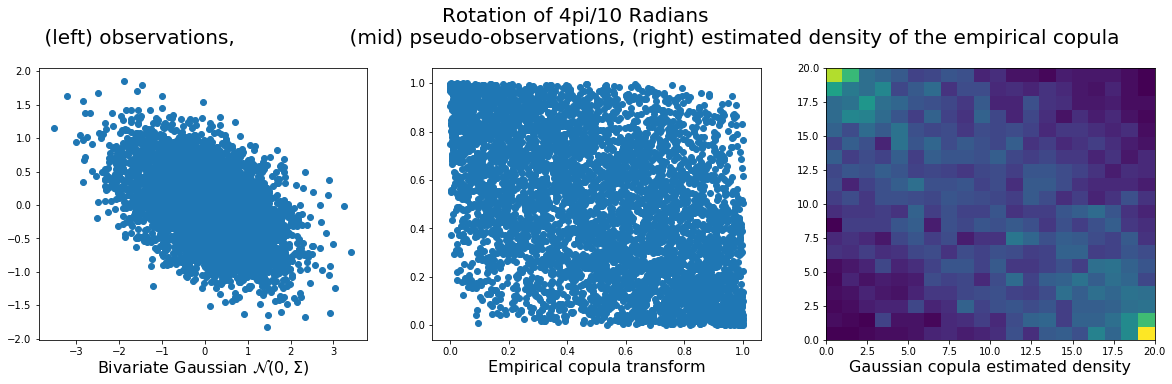

[[ 0.6464  0.1434  0.8394 ...,  0.2312  0.0472  0.5188]
 [ 0.7296  0.5524  0.0248 ...,  0.8834  0.1198  0.243 ]]


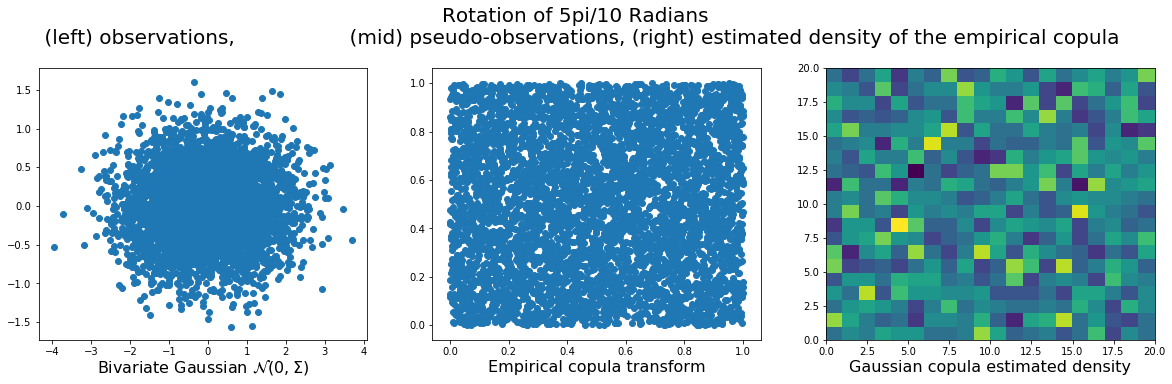

[[ 0.934   0.707   0.4356 ...,  0.631   0.3646  0.8394]
 [ 0.553   0.3754  0.7762 ...,  0.5066  0.1622  0.7608]]


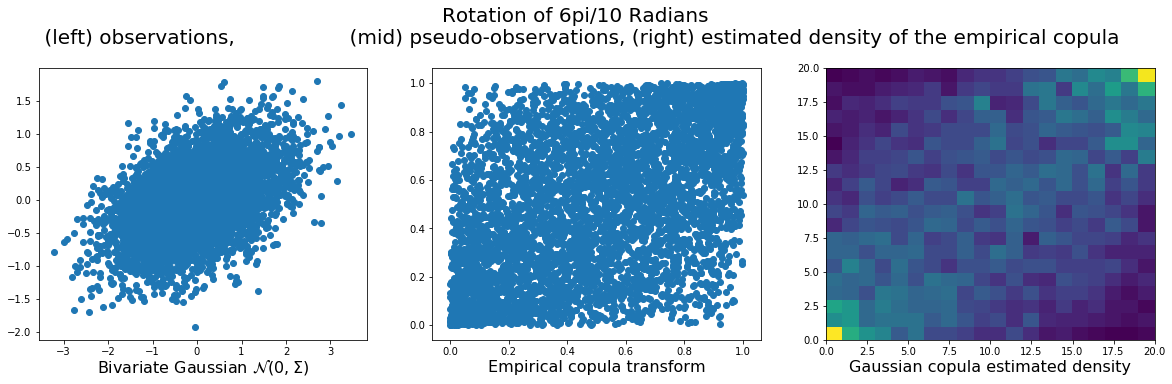

[[ 0.8836  0.104   0.2122 ...,  0.3254  0.7438  0.4468]
 [ 0.2326  0.1224  0.4386 ...,  0.7878  0.7892  0.672 ]]


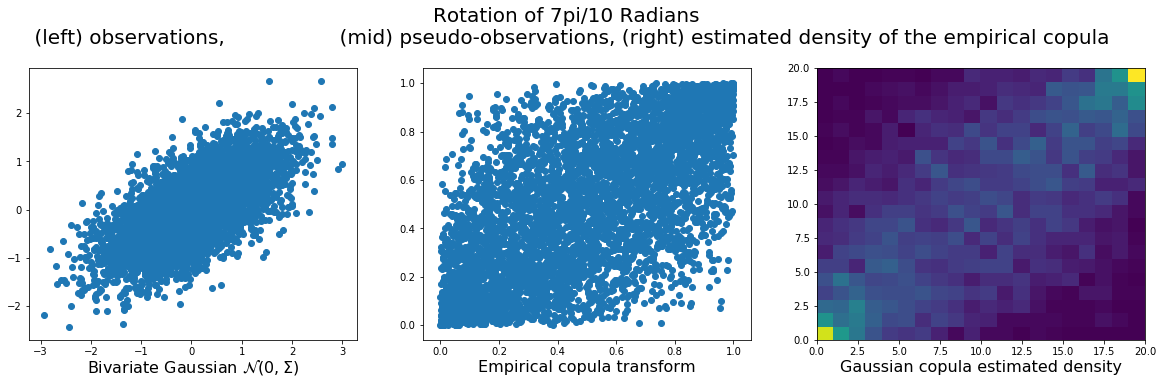

[[ 0.873   0.3352  0.7562 ...,  0.4752  0.2256  0.8376]
 [ 0.834   0.9716  0.9006 ...,  0.6216  0.4922  0.8994]]


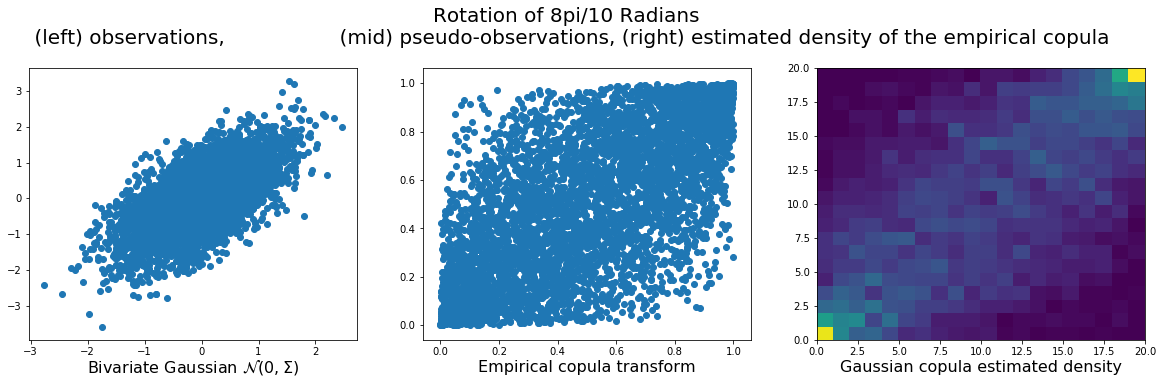

[[ 0.9286  0.7742  0.188  ...,  0.1986  0.3074  0.904 ]
 [ 0.577   0.8096  0.6076 ...,  0.5434  0.6682  0.9752]]


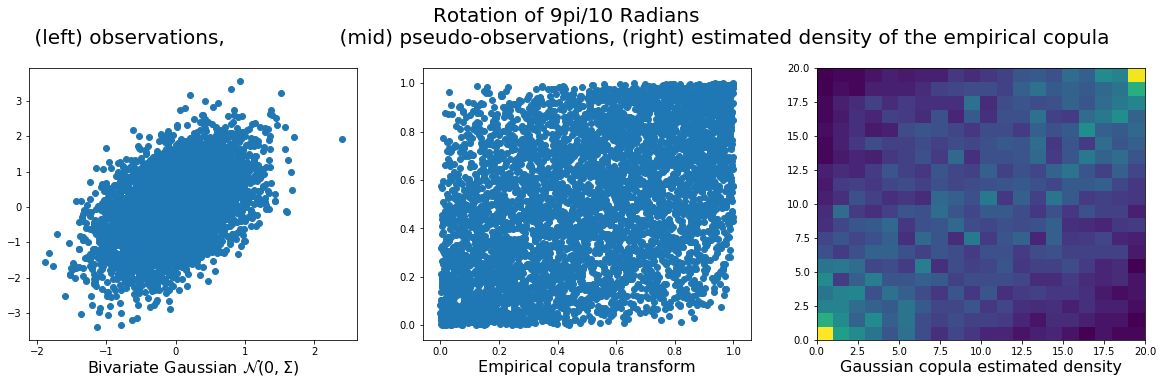

In [133]:
for i, X in enumerate(make_rotated_gaussians(5000, 10)):
    title = str(i) + 'pi/' + str(10)
    if i == 0:
        title = str(i)
    if i == 1:
        title = 'pi/' + str(10)
    _plot_copula(X, title)

/home/nitin/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:22: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


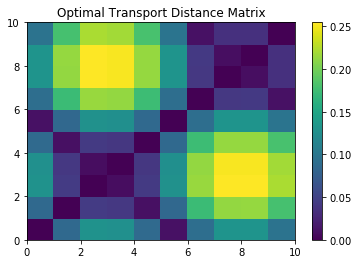

In [134]:
# get sigs
sigs = []
for X in make_rotated_gaussians(5000, 10):
    sigs.append(_get_sig(X))
_plot_distances(sigs)

In [135]:
def make_high_dim_gaussians(d):
    core_params = {
        'num_samples': 5000
    }
    high_dim_set = [
        {
            'type': 'gaussian',
            'mean': [0 for i in range(d)],
            'cov': np.identity(d)
        },
        {
            'type': 'gaussian',
            'mean': [1 for i in range(d)],
            'cov': np.identity(d)
        }
    ]
    return gen_samples(core_params, high_dim_set)

(12, 5000)
[[ 0.2674  0.7592  0.9402 ...,  0.4658  0.7988  0.9764]
 [ 0.4272  0.5092  0.0688 ...,  0.1436  0.452   0.2788]
 [ 0.8864  0.4636  0.073  ...,  0.5574  0.0508  0.0102]
 ..., 
 [ 0.9996  0.9142  0.119  ...,  0.0578  0.1076  0.5452]
 [ 0.0346  0.2536  0.2712 ...,  0.1494  0.687   0.489 ]
 [ 0.6186  0.7852  0.4322 ...,  0.2882  0.1364  0.8416]]


/home/nitin/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:22: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


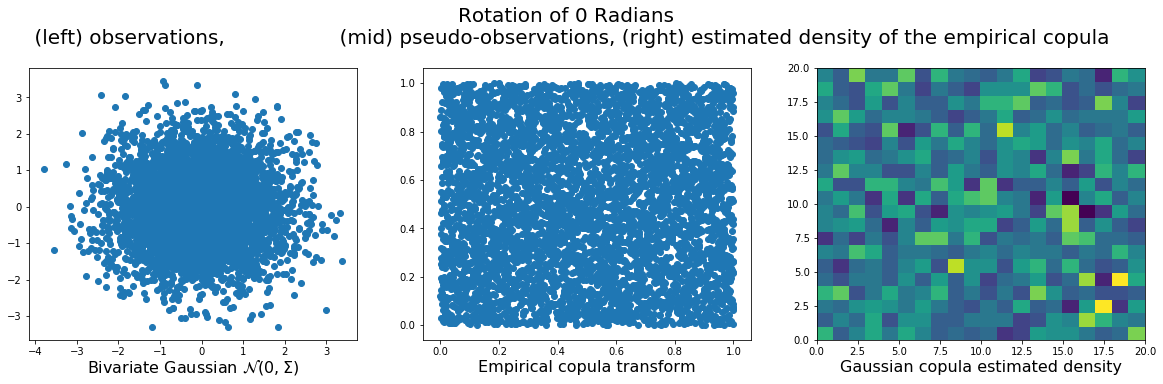

(12, 5000)
[[ 0.2708  0.01    0.172  ...,  0.3268  0.1054  0.8964]
 [ 0.251   0.536   0.879  ...,  0.7052  0.0504  0.7258]
 [ 0.568   0.8534  0.9726 ...,  0.6604  0.6126  0.8258]
 ..., 
 [ 0.1094  0.3058  0.6356 ...,  0.3334  0.8062  0.005 ]
 [ 0.0128  0.61    0.0098 ...,  0.3534  0.7286  0.6612]
 [ 0.3764  0.6528  0.3022 ...,  0.1588  0.3648  0.0064]]


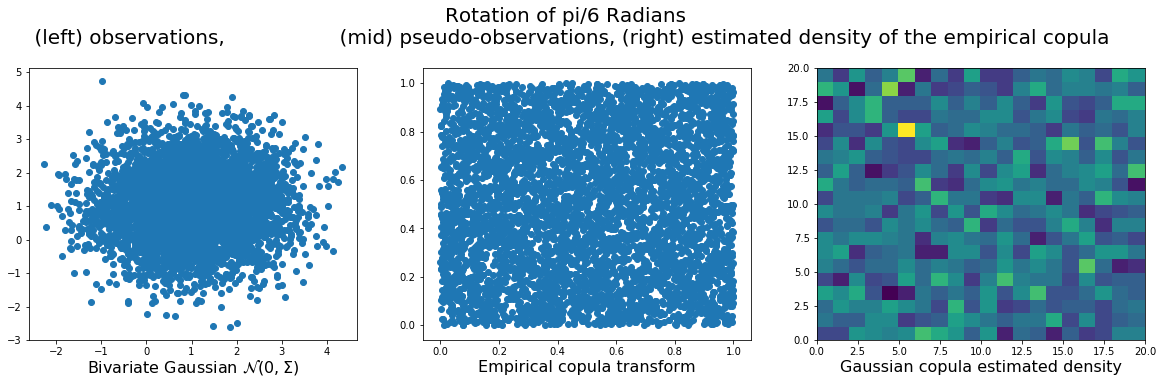

In [140]:
fitter = decomp.PCA(2)
for i, X in enumerate(make_high_dim_gaussians(12)):
    print X.shape
    title = str(i) + 'pi/' + str(6)
    if i == 0:
        title = str(i)
    if i == 1:
        title = 'pi/' + str(6)
    _plot_copula(X, title)

/home/nitin/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:22: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


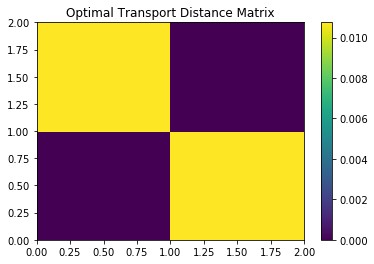

In [141]:
# get sigs
sigs = []
for X in make_high_dim_gaussians(12):
    sigs.append(_get_sig(X))
_plot_distances(sigs)

/home/nitin/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:22: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


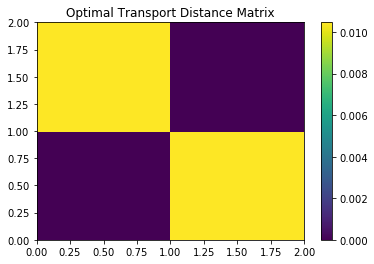

In [143]:
# get sigs
sigs = []
for X in make_high_dim_gaussians(60):
    sigs.append(_get_sig(X))
_plot_distances(sigs)

In [28]:
def get_patient(patient_num):
    # initialize patient
    patient = {}
    # set path to data
    patient_dir = "../../../../data/" + patient_num + "/EEG/raw/PANDA"
    # iterate through available datasets for given patient
    for filename in os.listdir(patient_dir):
        if filename.endswith(".pkl"): 
            # get a relevant name for holding the data
            meta_name = filename.split("_")[1]
            meta_name = meta_name[0].lower() + meta_name[1:]
            # load the data
            patient[meta_name] = pickle.load(open(patient_dir + "/" + filename, "rb" ))
            continue
        else:
            continue
    return patient

In [32]:
patient = get_patient('NDARAA075AMK')

[[ 1.          0.99453552  0.98907104 ...,  0.01639344  0.00819672
   0.00819672]
 [ 1.          0.99453552  0.98907104 ...,  0.01639344  0.01092896
   0.00546448]
 [ 1.          0.99453552  0.98907104 ...,  0.00546448  0.02185792
   0.01092896]
 ..., 
 [ 0.98907104  1.          0.99453552 ...,  0.25136612  0.35519126
   0.28961749]
 [ 0.99453552  1.          0.98907104 ...,  0.54644809  0.6557377
   0.65027322]
 [ 0.50273224  0.50273224  0.50273224 ...,  0.50273224  0.50273224
   0.50273224]]


/home/nitin/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:22: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


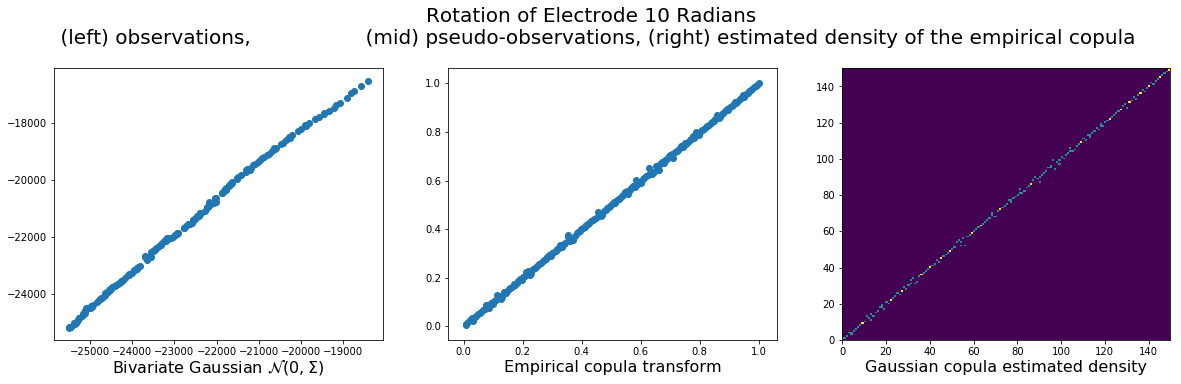

In [45]:

_plot_copula(patient['restingState'][:,::1000], title)